# PCアルゴリズム_pgmpy

* ベイジアンネットワークの手法の一つ(今回はpgmpyというものを使う)

In [1]:
!pip install pgmpy==0.1.11

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston


#pgmpyの読み込み
from pgmpy.estimators import K2Score, HillClimbSearch, ExhaustiveSearch
#ConstraintBasedEstimatorはpgmpy==0.1.11にあって、最新のpgmpyにはない
from pgmpy.estimators import ConstraintBasedEstimator  
from pgmpy.estimators import BicScore
from pgmpy.sampling import BayesianModelSampling
from pgmpy.models import BayesianModel

In [4]:
boston = load_boston()
df = pd.DataFrame(boston.data,columns=boston.feature_names)
#目的変数の追加
df['MEDV'] = boston.target
df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
# 離散値に変更
df_discrete = df.copy()

df_discrete['CRIM'] = pd.cut(df_discrete['CRIM'], 5)
df_discrete['ZN'] = pd.cut(df_discrete['ZN'], 5)
df_discrete['INDUS'] = pd.cut(df_discrete['INDUS'], 5)
df_discrete['CHAS'] = pd.cut(df_discrete['CHAS'], 5)
df_discrete['NOX'] = pd.cut(df_discrete['NOX'], 5)
df_discrete['RM'] = pd.cut(df_discrete['RM'], 5)
df_discrete['AGE'] = pd.cut(df_discrete['AGE'], 5)
df_discrete['DIS'] = pd.cut(df_discrete['DIS'], 5)
df_discrete['RAD'] = pd.cut(df_discrete['RAD'], 5)
df_discrete['TAX'] = pd.cut(df_discrete['TAX'], 5)
df_discrete['PTRATIO'] = pd.cut(df_discrete['PTRATIO'], 5)
df_discrete['B'] = pd.cut(df_discrete['B'], 5)
df_discrete['LSTAT'] = pd.cut(df_discrete['LSTAT'], 5)
df_discrete['MEDV'] = pd.cut(df_discrete['MEDV'], 5)

df_discrete.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,"(-0.0826, 17.8]","(-0.1, 20.0]","(0.433, 5.916]","(-0.001, 0.2]","(0.482, 0.579]","(5.649, 6.692]","(61.16, 80.58]","(3.329, 5.528]","(0.977, 5.6]","(291.8, 396.6]","(14.48, 16.36]","(317.584, 396.9]","(1.694, 8.978]","(23.0, 32.0]"
1,"(-0.0826, 17.8]","(-0.1, 20.0]","(5.916, 11.372]","(-0.001, 0.2]","(0.385, 0.482]","(5.649, 6.692]","(61.16, 80.58]","(3.329, 5.528]","(0.977, 5.6]","(186.476, 291.8]","(16.36, 18.24]","(317.584, 396.9]","(8.978, 16.226]","(14.0, 23.0]"
2,"(-0.0826, 17.8]","(-0.1, 20.0]","(5.916, 11.372]","(-0.001, 0.2]","(0.385, 0.482]","(6.692, 7.736]","(41.74, 61.16]","(3.329, 5.528]","(0.977, 5.6]","(186.476, 291.8]","(16.36, 18.24]","(317.584, 396.9]","(1.694, 8.978]","(32.0, 41.0]"
3,"(-0.0826, 17.8]","(-0.1, 20.0]","(0.433, 5.916]","(-0.001, 0.2]","(0.385, 0.482]","(6.692, 7.736]","(41.74, 61.16]","(5.528, 7.728]","(0.977, 5.6]","(186.476, 291.8]","(18.24, 20.12]","(317.584, 396.9]","(1.694, 8.978]","(32.0, 41.0]"
4,"(-0.0826, 17.8]","(-0.1, 20.0]","(0.433, 5.916]","(-0.001, 0.2]","(0.385, 0.482]","(6.692, 7.736]","(41.74, 61.16]","(5.528, 7.728]","(0.977, 5.6]","(186.476, 291.8]","(18.24, 20.12]","(317.584, 396.9]","(1.694, 8.978]","(32.0, 41.0]"


# PCアルゴリズム
* 最も代表的な古典的条件付き独立性検定による構造学習法
* PCアルゴリズムは連続値を扱えないため、離散値へ変更
* 独立性の検定により、変数間のスケルトン(方向のない依存関係)と特定
* V-structure,オリエンテーションルールにより一部のスケルトンに方向を付与

# 因果探索
* V-structure...V字構造を持った変数間の関係に着目し子ノード間で独立性がなければ(関係があれば)、親ノードに向かう矢印を加える。これは子ノードが決まれば親ノードも決まりやすいということを表している。
* オリエンテーションルール...部分的に矢印が得られている時に、追加で矢印を決定することができる場合がある。
* BIC...スコアベースアプローチはスケルトン(方向がない辺)に対して全てのパターンの矢印を加えた場合をBICで評価し、最も評価の良いものを採用する手法

In [8]:
est = ConstraintBasedEstimator(df_discrete)
#est = K2Score(df_discrete)

skel,seperating_sets = est.estimate_skeleton(significance_level=0.01)
print("Undirected edges:",skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:",pdag.edges())

model = est.pdag_to_dag(pdag)
print("DAG edges:",model.edges())


/usr/local/lib/python3.7/dist-packages/pgmpy/estimators/CITests.py:114: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  XZ_state_counts = XYZ_state_counts.sum(axis=1, level=Z)  # marginalize out Y
/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/pivot.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agged[v] = maybe_downcast_to_dtype(agged[v], data[v].dtype)
/usr/local/lib/python3.7/dist-packages/pgmpy/estimators/CITests.py:92: UserWarning: Insufficient data for testing ZN _|_ INDUS | ['NOX', 'DIS']. At least 2000 samples recommended, 506 present.
  f"Insufficient data for t

Undirected edges: [('ZN', 'DIS'), ('INDUS', 'NOX'), ('INDUS', 'TAX'), ('INDUS', 'PTRATIO'), ('NOX', 'DIS'), ('NOX', 'PTRATIO'), ('RM', 'MEDV'), ('AGE', 'LSTAT'), ('RAD', 'TAX'), ('RAD', 'PTRATIO'), ('TAX', 'PTRATIO'), ('LSTAT', 'MEDV')]
PDAG edges: [('ZN', 'DIS'), ('INDUS', 'NOX'), ('INDUS', 'TAX'), ('INDUS', 'PTRATIO'), ('NOX', 'INDUS'), ('RM', 'MEDV'), ('AGE', 'LSTAT'), ('DIS', 'ZN'), ('DIS', 'NOX'), ('RAD', 'TAX'), ('RAD', 'PTRATIO'), ('TAX', 'INDUS'), ('TAX', 'RAD'), ('TAX', 'PTRATIO'), ('PTRATIO', 'INDUS'), ('LSTAT', 'AGE'), ('LSTAT', 'MEDV'), ('MEDV', 'RM'), ('MEDV', 'LSTAT')]
DAG edges: [('INDUS', 'NOX'), ('INDUS', 'TAX'), ('INDUS', 'PTRATIO'), ('DIS', 'NOX'), ('DIS', 'ZN'), ('RAD', 'PTRATIO'), ('RAD', 'TAX'), ('TAX', 'PTRATIO'), ('LSTAT', 'AGE'), ('MEDV', 'RM'), ('MEDV', 'LSTAT')]


/usr/local/lib/python3.7/dist-packages/pgmpy/estimators/ConstraintBasedEstimator.py:343: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  + "oriented arbitrarily."


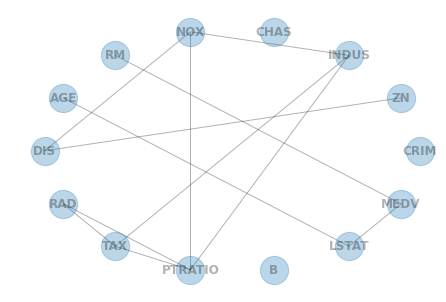

In [9]:
# Undirected edges（方向性なし）可視化
G = nx.Graph()
G.add_nodes_from(df.columns) # ノード
G.add_edges_from(skel.edges()) # 辺
nx.draw_circular(G, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight='bold')
plt.show()

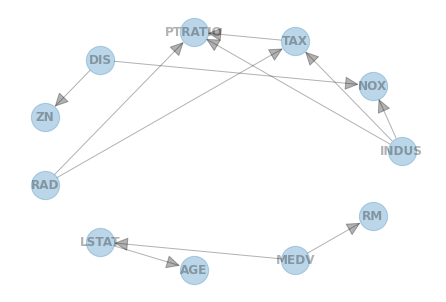

In [10]:
# DAG edges(方向性あり)可視化
DAG_model = BayesianModel(model.edges())
nx.draw_circular(DAG_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight='bold')
plt.show()

* INDUSとRADはSTRATIOと因果関係がある
* TAXとPTRATIOは疑似相関だと考えられる

# 因果推論